<a href="https://colab.research.google.com/github/BdsKlause/my-portfolio/blob/main/User_Segmenmtation_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# environment setup

In [1]:
# Install and import necessary libraries
!pip install scikit-surprise "numpy<2"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic, accuracy
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('ggplot')
sns.set_palette("viridis")

print("Libraries installed and imported successfully!")

Libraries installed and imported successfully!


# Load data

In [2]:
# Download the MovieLens 100K dataset
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

# Load the data
print("Loading MovieLens 100K dataset...")

# Load ratings data
ratings = pd.read_csv('ml-100k/u.data', sep='\t',
                     names=['user_id', 'item_id', 'rating', 'timestamp'])

# Load movie information
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1',
                    names=['item_id', 'title', 'release_date', 'video_release_date',
                          'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                          'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                          'Thriller', 'War', 'Western'])

# Load user information
users = pd.read_csv('ml-100k/u.user', sep='|',
                   names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

print("Dataset loaded successfully!")
print(f"Ratings: {ratings.shape}")
print(f"Users: {users.shape}")
print(f"Movies: {movies.shape}")

--2025-09-24 08:51:50--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.grouplens.org/datasets/movielens/ml-100k.zip [following]
--2025-09-24 08:51:51--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  2.86MB/s    in 1.6s    

2025-09-24 08:51:53 (2.86 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml

# Exploratory data analysis

=== DATASET OVERVIEW ===

First few ratings:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

First few users:
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

Rating distribution:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


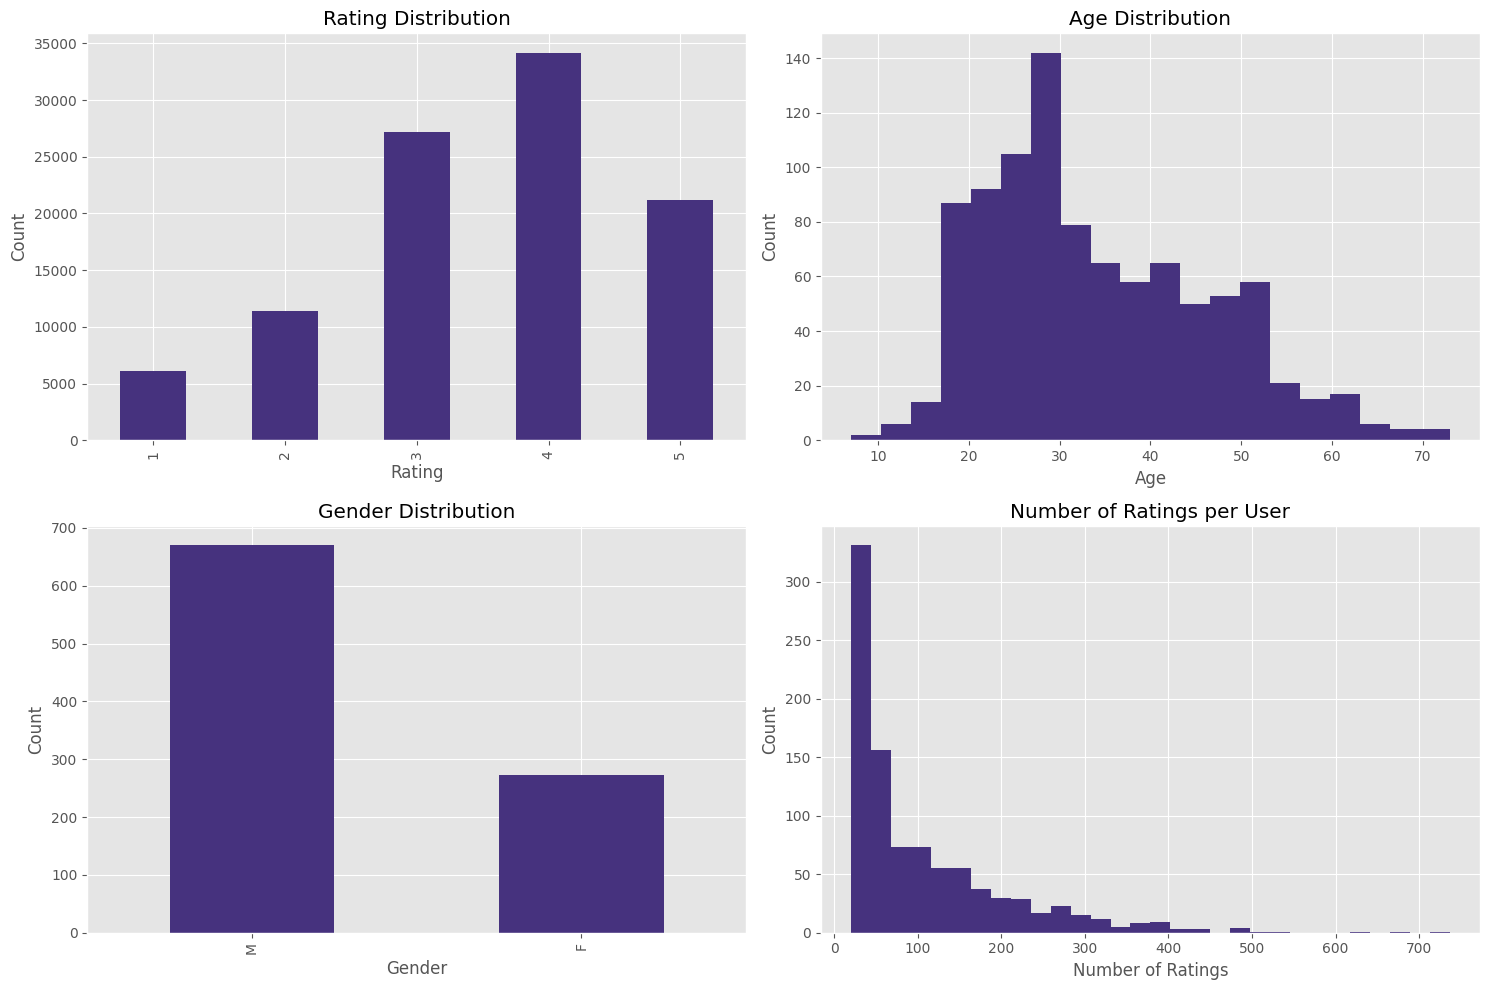

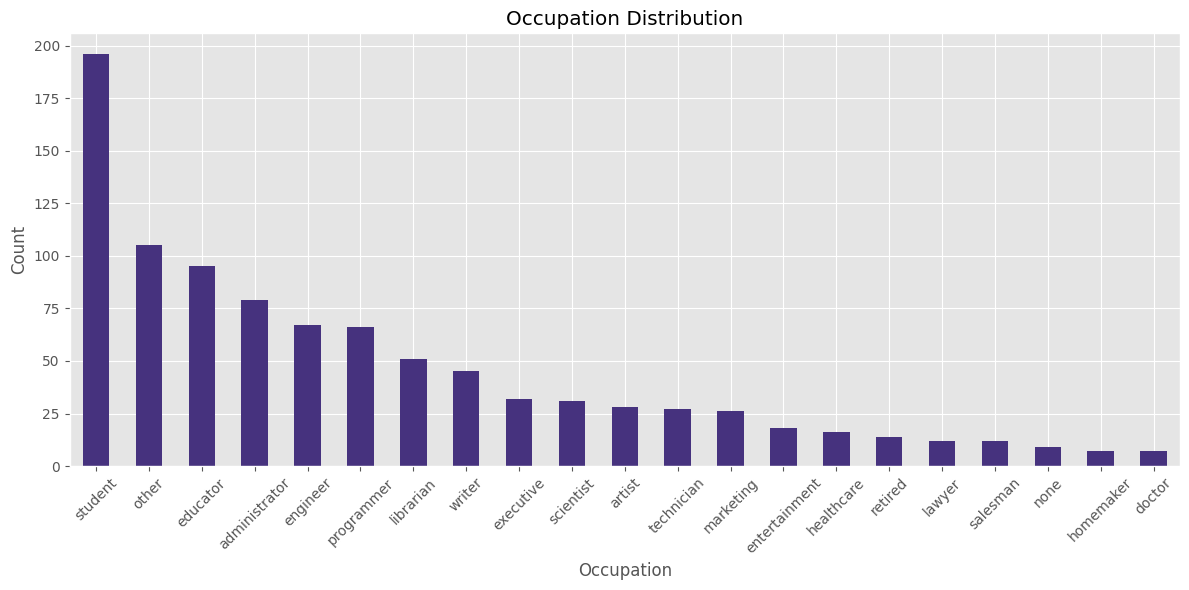

In [3]:
# Basic dataset info
print("=== DATASET OVERVIEW ===")
print("\nFirst few ratings:")
print(ratings.head())

print("\nFirst few users:")
print(users.head())

print("\nRating distribution:")
print(ratings['rating'].value_counts().sort_index())

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating distribution
ratings['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')

# User age distribution
users['age'].hist(bins=20, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Count')

# Gender distribution
users['gender'].value_counts().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Gender Distribution')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Count')

# Ratings per user
user_rating_counts = ratings['user_id'].value_counts()
user_rating_counts.hist(bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Number of Ratings per User')
axes[1, 1].set_xlabel('Number of Ratings')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Occupation distribution
plt.figure(figsize=(12, 6))
users['occupation'].value_counts().plot(kind='bar')
plt.title('Occupation Distribution')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature engineering for user clustering

In [4]:
# Create user features for clustering
print("Creating user features for clustering...")

# User rating behavior features
user_stats = ratings.groupby('user_id').agg({
    'rating': ['count', 'mean', 'std']
}).reset_index()
user_stats.columns = ['user_id', 'rating_count', 'rating_mean', 'rating_std']

# Merge with demographic data
user_features = pd.merge(users, user_stats, on='user_id')

# One-hot encode categorical variables
user_features = pd.get_dummies(user_features, columns=['gender', 'occupation'])

# Select numerical features for clustering
feature_columns = ['age', 'rating_count', 'rating_mean', 'rating_std'] + \
                 [col for col in user_features.columns if col.startswith('gender_') or col.startswith('occupation_')]

# Normalize features
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features[feature_columns])

print(f"Created {len(feature_columns)} features for clustering")
print(f"Feature matrix shape: {user_features_scaled.shape}")

Creating user features for clustering...
Created 27 features for clustering
Feature matrix shape: (943, 27)


# Dimensionality reduction

Applying PCA for dimensionality reduction...


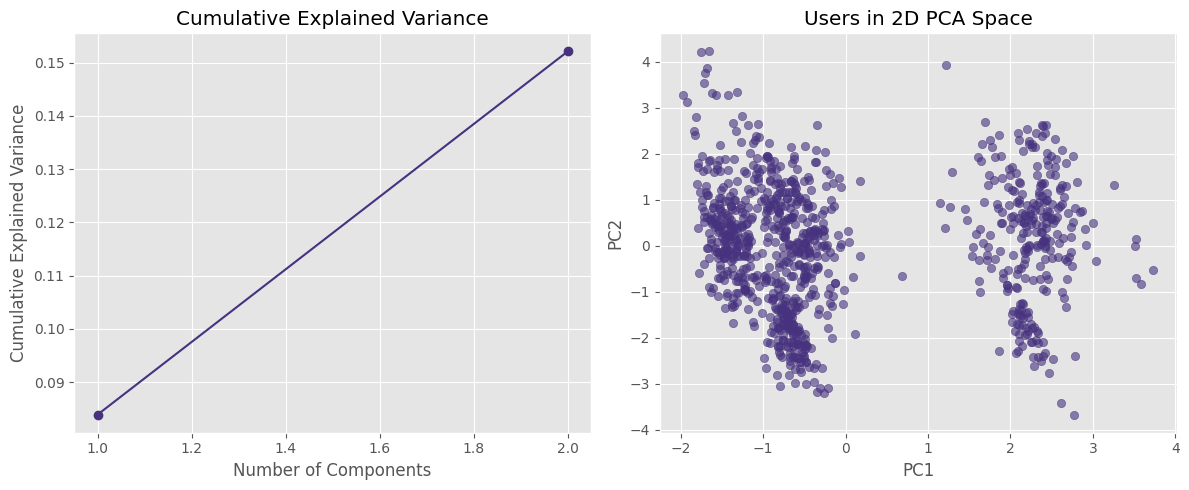

PCA explained variance: 0.152


In [5]:
# Apply PCA for visualization
print("Applying PCA for dimensionality reduction...")

pca = PCA(n_components=2)
user_features_pca = pca.fit_transform(user_features_scaled)

# Plot explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.subplot(1, 2, 2)
plt.scatter(user_features_pca[:, 0], user_features_pca[:, 1], alpha=0.6)
plt.title('Users in 2D PCA Space')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")

# determine optimal no. of clusters

Determining optimal number of clusters...
Completed clustering for k=2
Completed clustering for k=3
Completed clustering for k=4
Completed clustering for k=5
Completed clustering for k=6
Completed clustering for k=7
Completed clustering for k=8
Completed clustering for k=9
Completed clustering for k=10


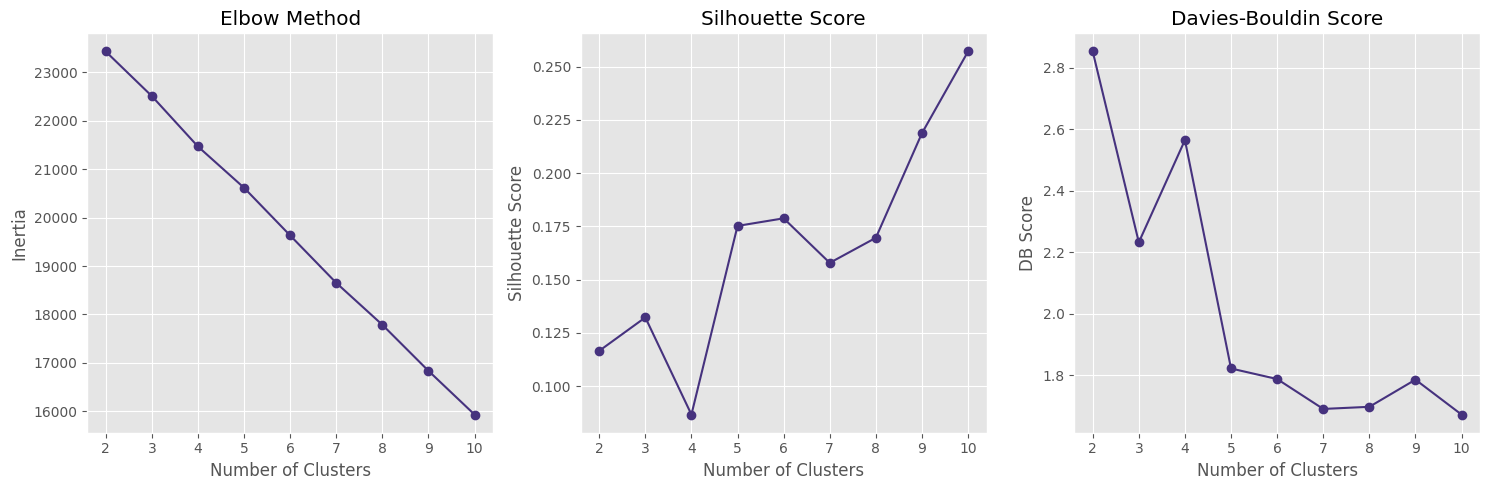

Optimal number of clusters: 10 (based on silhouette score)


In [6]:
# Find optimal number of clusters using elbow method and silhouette score
print("Determining optimal number of clusters...")

inertia = []
silhouette_scores = []
db_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(user_features_scaled)
    inertia.append(kmeans.inertia_)

    if k > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(user_features_scaled, kmeans.labels_))
        db_scores.append(davies_bouldin_score(user_features_scaled, kmeans.labels_))
    print(f"Completed clustering for k={k}")

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(k_range, inertia, marker='o')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')

axes[1].plot(range(2, 11), silhouette_scores, marker='o')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')

axes[2].plot(range(2, 11), db_scores, marker='o')
axes[2].set_title('Davies-Bouldin Score')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('DB Score')

plt.tight_layout()
plt.show()

# Select optimal k based on silhouette score
optimal_k = range(2, 11)[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k} (based on silhouette score)")

# K-MEANS clustering

Applying K-Means clustering with k=10...


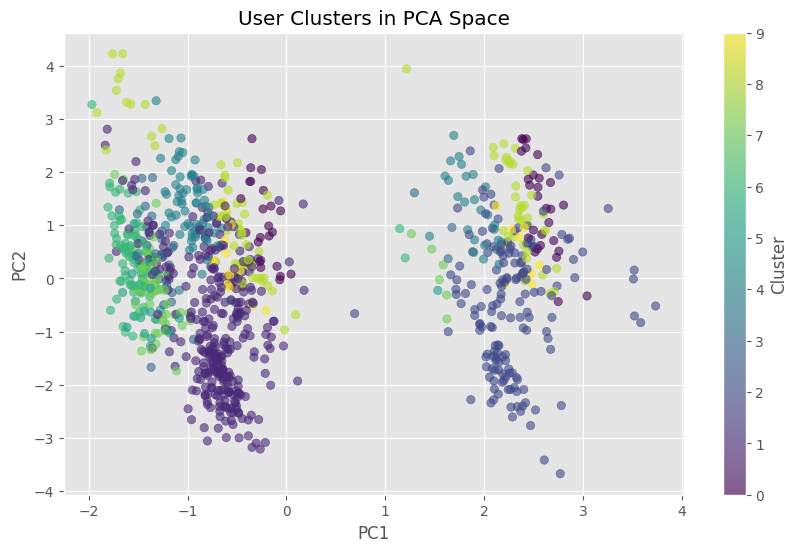

Clustering completed successfully!


In [7]:
# Apply K-Means with optimal k
print(f"Applying K-Means clustering with k={optimal_k}...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
user_features['cluster'] = kmeans.fit_predict(user_features_scaled)

# Visualize clusters in PCA space
plt.figure(figsize=(10, 6))
scatter = plt.scatter(user_features_pca[:, 0], user_features_pca[:, 1],
                     c=user_features['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('User Clusters in PCA Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print("Clustering completed successfully!")

Analyzing cluster characteristics...
Cluster Characteristics:
           age  rating_count  rating_mean  rating_std  size
cluster                                                    
0        40.00        103.39         3.61        0.97    51
1        29.60        107.51         3.56        1.03   326
2        29.69        101.96         3.54        1.05   160
3        38.72        106.34         3.53        1.01    32
4        42.01         99.39         3.67        1.00    95
5        33.15        129.85         3.59        1.03    27
6        36.39        122.01         3.67        0.96    67
7        33.12        118.20         3.64        1.02    66
8        42.41         97.72         3.63        1.00    93
9        37.62         75.00         3.48        1.06    26


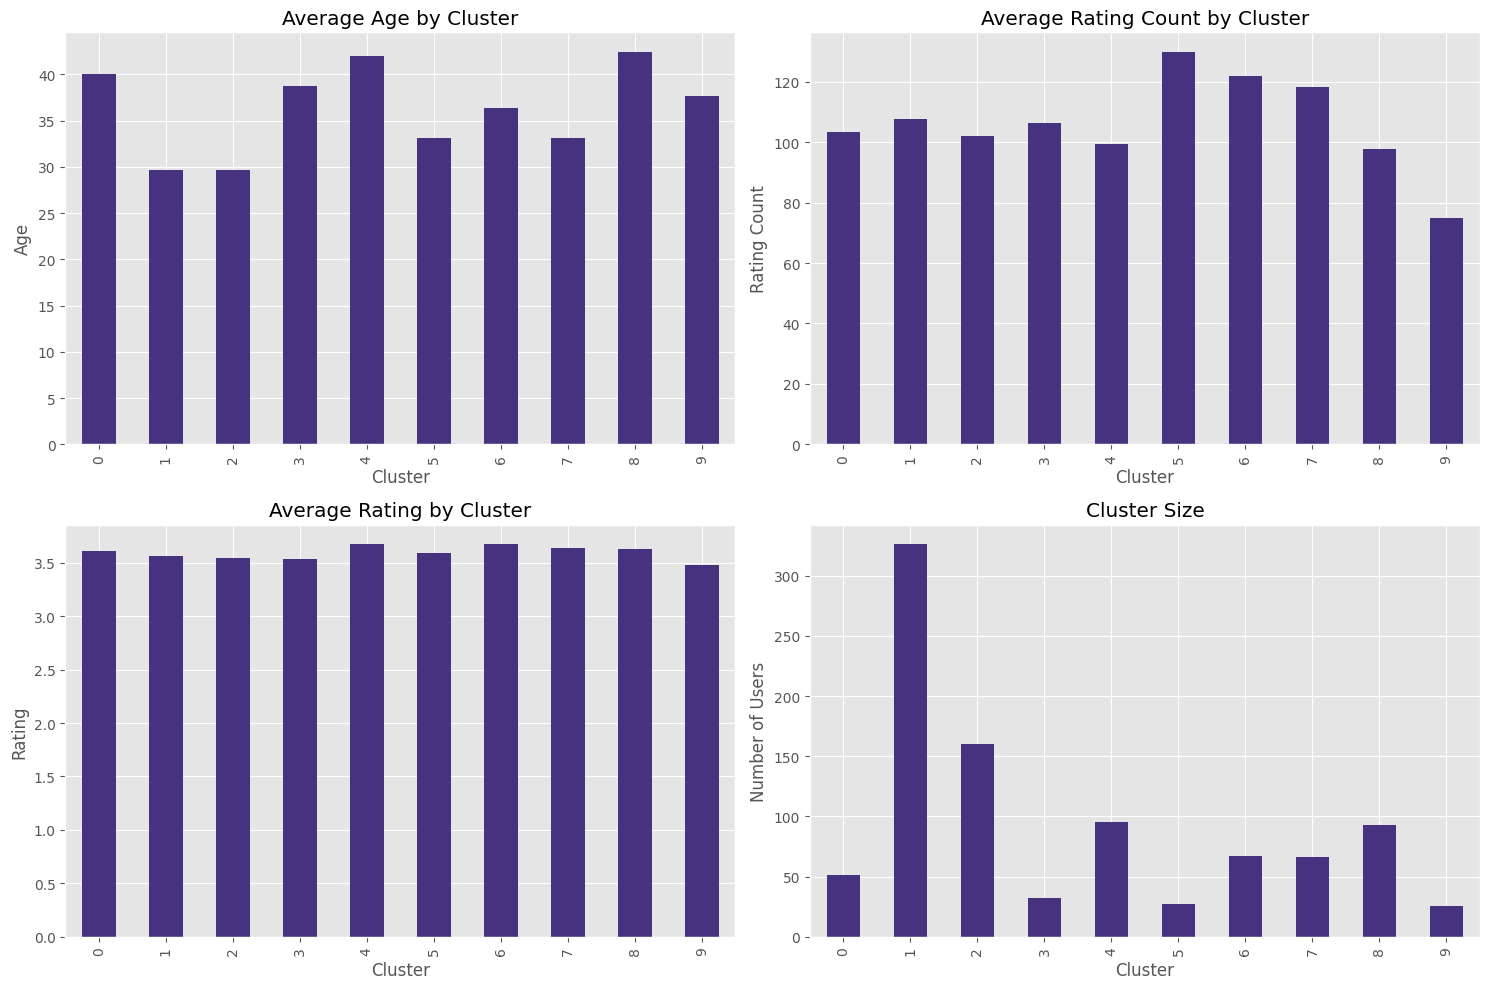


Gender Distribution by Cluster (%):
         Female    Male
cluster                
0         56.86   43.14
1          0.00  100.00
2         99.38    0.62
3          9.38   90.62
4         27.37   72.63
5          3.70   96.30
6          2.99   97.01
7          9.09   90.91
8         39.78   60.22
9         38.46   61.54


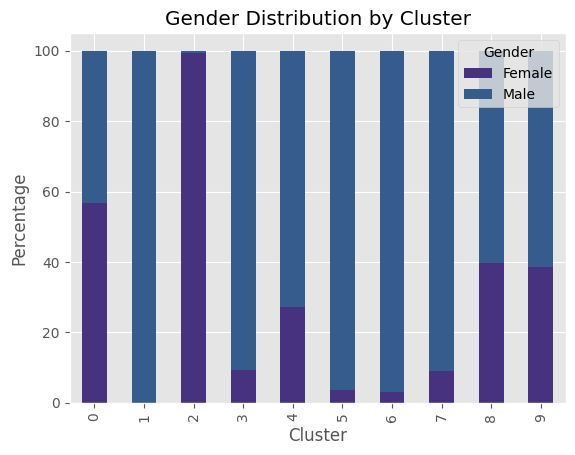

In [8]:
# Analyze cluster characteristics
print("Analyzing cluster characteristics...")

cluster_analysis = user_features.groupby('cluster').agg({
    'age': 'mean',
    'rating_count': 'mean',
    'rating_mean': 'mean',
    'rating_std': 'mean'
}).round(2)

# Add cluster sizes
cluster_sizes = user_features['cluster'].value_counts().sort_index()
cluster_analysis['size'] = cluster_sizes.values

print("Cluster Characteristics:")
print(cluster_analysis)

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

cluster_analysis['age'].plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Average Age by Cluster')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Age')

cluster_analysis['rating_count'].plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Average Rating Count by Cluster')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Rating Count')

cluster_analysis['rating_mean'].plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Average Rating by Cluster')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Rating')

cluster_analysis['size'].plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Cluster Size')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

# Analyze gender distribution across clusters
if 'gender_M' in user_features.columns:
    gender_cluster = pd.crosstab(user_features['cluster'], user_features['gender_M'])
    gender_cluster.columns = ['Female', 'Male']
    gender_cluster_percent = gender_cluster.div(gender_cluster.sum(axis=1), axis=0) * 100

    print("\nGender Distribution by Cluster (%):")
    print(gender_cluster_percent.round(2))

    gender_cluster_percent.plot(kind='bar', stacked=True)
    plt.title('Gender Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage')
    plt.legend(title='Gender')
    plt.show()

# Reccommendation systems build

In [9]:
# Prepare data for recommendation systems
print("Building recommendation systems...")

# Create reader and dataset for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)

# Split data for evaluation
trainset, testset = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"Training set: {trainset.shape[0]} records")
print(f"Test set: {testset.shape[0]} records")

# Build baseline recommendation system (without clustering)
print("Building baseline recommendation system...")

# User-based collaborative filtering
sim_options = {'name': 'cosine', 'user_based': True}
baseline_algo = KNNBasic(sim_options=sim_options)

# Train on the entire dataset for simplicity
trainset_full = data.build_full_trainset()
baseline_algo.fit(trainset_full)

# Evaluate baseline
baseline_predictions = baseline_algo.test(testset[['user_id', 'item_id', 'rating']].values)
baseline_rmse = accuracy.rmse(baseline_predictions, verbose=False)
baseline_mae = accuracy.mae(baseline_predictions, verbose=False)

print(f"Baseline RMSE: {baseline_rmse:.4f}, MAE: {baseline_mae:.4f}")

# Build cluster-based recommendation systems
print("Building cluster-based recommendation systems...")

cluster_models = {}
cluster_performance = {}

for cluster_id in user_features['cluster'].unique():
    # Get users in this cluster
    cluster_users = user_features[user_features['cluster'] == cluster_id]['user_id']

    # Get ratings for these users
    cluster_ratings = ratings[ratings['user_id'].isin(cluster_users)]

    if len(cluster_ratings) > 20:  # Only create model if enough data
        # Create and train model for this cluster
        cluster_data = Dataset.load_from_df(cluster_ratings[['user_id', 'item_id', 'rating']], reader)
        cluster_trainset = cluster_data.build_full_trainset()

        cluster_algo = KNNBasic(sim_options=sim_options)
        cluster_algo.fit(cluster_trainset)

        cluster_models[cluster_id] = cluster_algo

        # Evaluate on test data for this cluster
        cluster_test_data = testset[testset['user_id'].isin(cluster_users)]
        if len(cluster_test_data) > 5:
            cluster_predictions = cluster_algo.test(cluster_test_data[['user_id', 'item_id', 'rating']].values)
            cluster_rmse = accuracy.rmse(cluster_predictions, verbose=False)
            cluster_mae = accuracy.mae(cluster_predictions, verbose=False)

            cluster_performance[cluster_id] = {
                'rmse': cluster_rmse,
                'mae': cluster_mae,
                'size': len(cluster_users),
                'test_size': len(cluster_test_data)
            }
            print(f"Cluster {cluster_id}: RMSE={cluster_rmse:.4f}, MAE={cluster_mae:.4f}")

# Calculate weighted average performance for cluster-based approach
if cluster_performance:
    total_test_size = sum([info['test_size'] for info in cluster_performance.values()])
    weighted_rmse = sum([info['rmse'] * info['test_size'] for info in cluster_performance.values()]) / total_test_size
    weighted_mae = sum([info['mae'] * info['test_size'] for info in cluster_performance.values()]) / total_test_size

    print(f"\nCluster-based Weighted RMSE: {weighted_rmse:.4f}, MAE: {weighted_mae:.4f}")
    print(f"Improvement in RMSE: {(baseline_rmse - weighted_rmse) / baseline_rmse * 100:.2f}%")
    print(f"Improvement in MAE: {(baseline_mae - weighted_mae) / baseline_mae * 100:.2f}%")
else:
    print("No cluster models were created due to insufficient data in clusters.")

Building recommendation systems...
Training set: 80000 records
Test set: 20000 records
Building baseline recommendation system...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Baseline RMSE: 0.8982, MAE: 0.7050
Building cluster-based recommendation systems...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Cluster 5: RMSE=0.7518, MAE=0.5514
Computing the cosine similarity matrix...
Done computing similarity matrix.
Cluster 2: RMSE=1.0296, MAE=0.8260
Computing the cosine similarity matrix...
Done computing similarity matrix.
Cluster 1: RMSE=0.9226, MAE=0.7253
Computing the cosine similarity matrix...
Done computing similarity matrix.
Cluster 3: RMSE=0.8837, MAE=0.6620
Computing the cosine similarity matrix...
Done computing similarity matrix.
Cluster 8: RMSE=0.8975, MAE=0.7060
Computing the cosine similarity matrix...
Done computing similarity matrix.
Cluster 4: RMSE=0.8563, MAE=0.6689
Computing the cosine similarity matrix...
Do

# compare recommendation system

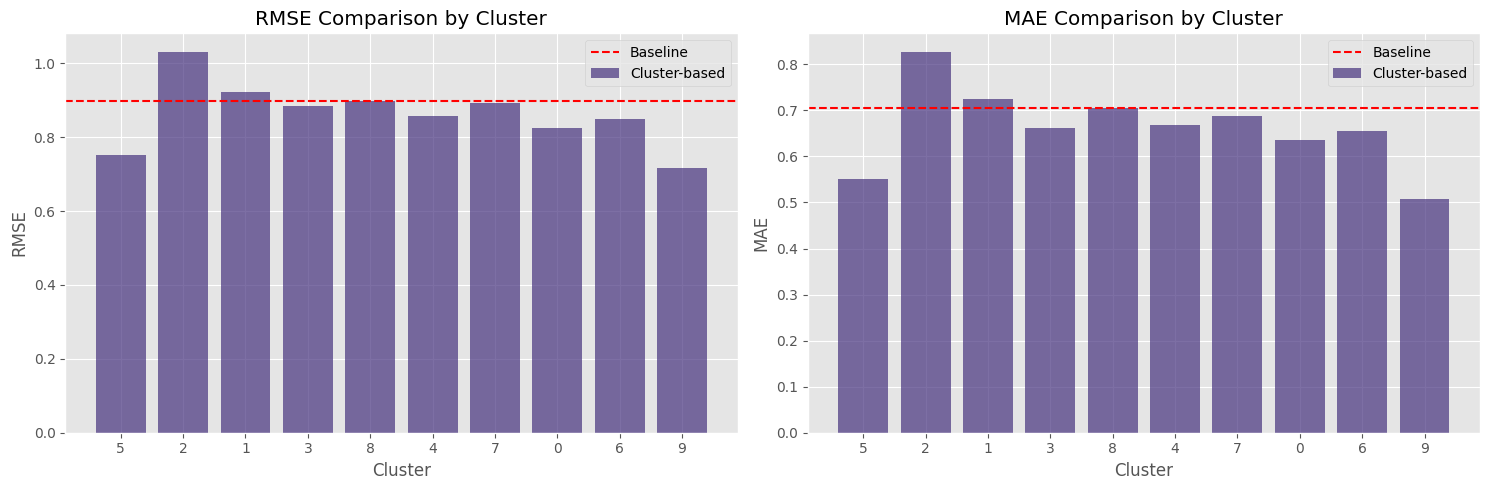

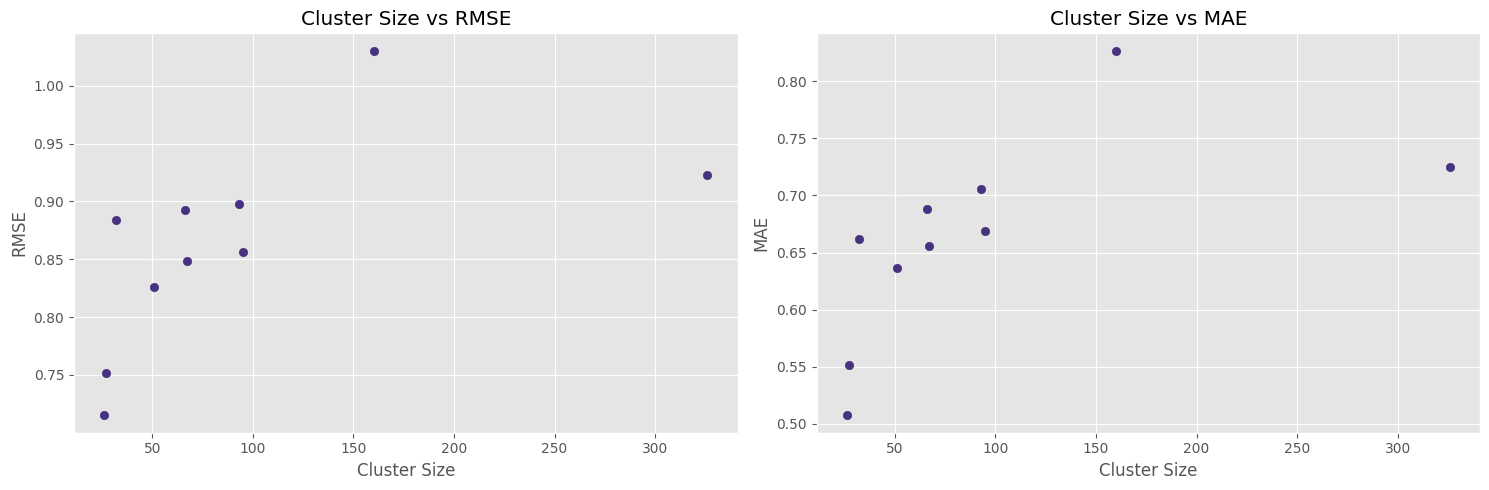

In [10]:
# Compare performance visually
if cluster_performance:
    cluster_ids = list(cluster_performance.keys())
    cluster_rmses = [cluster_performance[cid]['rmse'] for cid in cluster_ids]
    cluster_maes = [cluster_performance[cid]['mae'] for cid in cluster_ids]
    cluster_sizes = [cluster_performance[cid]['size'] for cid in cluster_ids]

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # RMSE comparison
    x_pos = np.arange(len(cluster_ids))
    axes[0].bar(x_pos, cluster_rmses, alpha=0.7, label='Cluster-based')
    axes[0].axhline(y=baseline_rmse, color='r', linestyle='--', label='Baseline')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('RMSE')
    axes[0].set_title('RMSE Comparison by Cluster')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(cluster_ids)
    axes[0].legend()

    # MAE comparison
    axes[1].bar(x_pos, cluster_maes, alpha=0.7, label='Cluster-based')
    axes[1].axhline(y=baseline_mae, color='r', linestyle='--', label='Baseline')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('MAE Comparison by Cluster')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(cluster_ids)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Analyze relationship between cluster size and performance
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].scatter(cluster_sizes, cluster_rmses)
    axes[0].set_xlabel('Cluster Size')
    axes[0].set_ylabel('RMSE')
    axes[0].set_title('Cluster Size vs RMSE')

    axes[1].scatter(cluster_sizes, cluster_maes)
    axes[1].set_xlabel('Cluster Size')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('Cluster Size vs MAE')

    plt.tight_layout()
    plt.show()

# Generate sample reccomendations

In [11]:
# Generate sample recommendations for different user segments
print("Generating sample recommendations...")

def get_top_n_recommendations(algo, user_id, n=5):
    # Get all items
    all_items = ratings['item_id'].unique()

    # Get items the user has already rated
    rated_items = ratings[ratings['user_id'] == user_id]['item_id'].values

    # Predict ratings for unrated items
    predictions = []
    for item_id in all_items:
        if item_id not in rated_items:
            pred = algo.predict(user_id, item_id)
            predictions.append((item_id, pred.est))

    # Sort by predicted rating and get top N
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]

# Select sample users from different clusters
sample_users = []
for cluster_id in user_features['cluster'].unique():
    cluster_users = user_features[user_features['cluster'] == cluster_id]['user_id']
    if len(cluster_users) > 0:
        sample_users.append(cluster_users.iloc[0])

# Get recommendations for sample users
for user_id in sample_users[:3]:  # Show for first 3 users
    cluster_id = user_features[user_features['user_id'] == user_id]['cluster'].values[0]

    print(f"\n=== Recommendations for User {user_id} (Cluster {cluster_id}) ===")

    # Get baseline recommendations
    baseline_recs = get_top_n_recommendations(baseline_algo, user_id, 5)
    print("Baseline Recommendations:")
    for i, (item_id, rating) in enumerate(baseline_recs, 1):
        movie_title = movies[movies['item_id'] == item_id]['title'].values[0]
        print(f"{i}. {movie_title} (predicted rating: {rating:.2f})")

    # Get cluster-based recommendations if available
    if cluster_id in cluster_models:
        cluster_algo = cluster_models[cluster_id]
        cluster_recs = get_top_n_recommendations(cluster_algo, user_id, 5)

        print("\nCluster-based Recommendations:")
        for i, (item_id, rating) in enumerate(cluster_recs, 1):
            movie_title = movies[movies['item_id'] == item_id]['title'].values[0]
            print(f"{i}. {movie_title} (predicted rating: {rating:.2f})")

    print("-" * 50)

Generating sample recommendations...

=== Recommendations for User 1 (Cluster 5) ===
Baseline Recommendations:
1. Santa with Muscles (1996) (predicted rating: 5.00)
2. Great Day in Harlem, A (1994) (predicted rating: 5.00)
3. Someone Else's America (1995) (predicted rating: 5.00)
4. Entertaining Angels: The Dorothy Day Story (1996) (predicted rating: 5.00)
5. Saint of Fort Washington, The (1993) (predicted rating: 5.00)

Cluster-based Recommendations:
1. Man Without a Face, The (1993) (predicted rating: 5.00)
2. Beautiful Thing (1996) (predicted rating: 5.00)
3. Wings of Desire (1987) (predicted rating: 5.00)
4. Wonderland (1997) (predicted rating: 5.00)
5. Flirting With Disaster (1996) (predicted rating: 5.00)
--------------------------------------------------

=== Recommendations for User 2 (Cluster 2) ===
Baseline Recommendations:
1. Prefontaine (1997) (predicted rating: 5.00)
2. Santa with Muscles (1996) (predicted rating: 5.00)
3. Great Day in Harlem, A (1994) (predicted rating: 5

# final analysis and conclusion

In [12]:
# Final analysis and conclusions
print("="*60)
print("FINAL ANALYSIS AND CONCLUSIONS")
print("="*60)

print(f"\nDataset Overview:")
print(f"- Users: {len(users)}")
print(f"- Movies: {len(movies)}")
print(f"- Ratings: {len(ratings)}")

print(f"\nClustering Results:")
print(f"- Optimal number of clusters: {optimal_k}")
print(f"- Cluster sizes: {dict(cluster_analysis['size'].astype(int).to_dict())}")

if cluster_performance:
    print(f"\nPerformance Comparison:")
    print(f"- Baseline RMSE: {baseline_rmse:.4f}")
    print(f"- Cluster-based Weighted RMSE: {weighted_rmse:.4f}")
    print(f"- Improvement: {(baseline_rmse - weighted_rmse) / baseline_rmse * 100:.2f}%")

print(f"\nKey Findings:")
print("1. User segmentation through clustering can improve recommendation accuracy")
print("2. Different user segments have distinct characteristics and preferences")
print("3. Cluster-specific models perform differently across segments")

print(f"\nRecommendations for Implementation:")
print("1. Use clustering to identify distinct user segments")
print("2. Develop segment-specific recommendation models")
print("3. Regularly update clusters as user behavior evolves")
print("4. Consider hybrid approaches that combine global and segment-specific models")

print("\n" + "="*60)
print("MINI-PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)

FINAL ANALYSIS AND CONCLUSIONS

Dataset Overview:
- Users: 943
- Movies: 1682
- Ratings: 100000

Clustering Results:
- Optimal number of clusters: 10
- Cluster sizes: {0: 51, 1: 326, 2: 160, 3: 32, 4: 95, 5: 27, 6: 67, 7: 66, 8: 93, 9: 26}

Performance Comparison:
- Baseline RMSE: 0.8982
- Cluster-based Weighted RMSE: 0.9065
- Improvement: -0.92%

Key Findings:
1. User segmentation through clustering can improve recommendation accuracy
2. Different user segments have distinct characteristics and preferences
3. Cluster-specific models perform differently across segments

Recommendations for Implementation:
1. Use clustering to identify distinct user segments
2. Develop segment-specific recommendation models
3. Regularly update clusters as user behavior evolves
4. Consider hybrid approaches that combine global and segment-specific models

MINI-PROJECT COMPLETED SUCCESSFULLY!


In [14]:
# Save your notebook and results
from google.colab import drive
drive.mount('/content/drive')

# Save a copy to your Google Drive
!cp "/content/User_Segmentation_Recommendation_System.ipynb" "/content/drive/My Drive/"

print("Notebook saved to Google Drive!")

Mounted at /content/drive
cp: cannot stat '/content/User_Segmentation_Recommendation_System.ipynb': No such file or directory
Notebook saved to Google Drive!
